In [ ]:
from cvxopt import matrix, spmatrix
from numpy import array

##Граница эффективности для портфеля акций


Выберем 5 классов активов:

1	US Mid Cap Value

2	US Mid Cap Growth 

3	European Stocks	

4	Precious Metals	

5	Intermediate Term Treasury

|Asset| Средняя дох-сть|Отклонение|
|--|--|--|
|US Mid Cap Value	|13.35%	|16.51%|
|US Mid Cap Growth|	13.65%|	18.76%|
|European Stocks	|10.47%|	17.72%|
|Precious Metals	|11.84%	|30.89%|
|Intermediate Term Treasury	|	6.24%	|4.80%|


|Asset	|US Mid Cap Value	|US Mid Cap Growth	|European Stocks	|Precious Metals	|Intermediate Term Treasury|
|-------------------|------|------|------|------|------|
|US Mid Cap Value	|1.00	|0.82	|0.74	|0.39	|-0.09 |
|US Mid Cap Growth	|0.82	|1.00	|0.73	|0.39	|-0.13 |
|European Stocks	|0.74	|0.73	|1.00	|0.43	|-0.07 |
|Precious Metals	|0.39	|0.39	|0.43	|1.00	|-0.01|
|Intermediate Term Treasury	|-0.09	|-0.13	|-0.07	|-0.01	|1.00 |


In [ ]:
expected_return = array([13.35, 13.65, 10.47,11.84,6.24]) / 100
standard_deviation = array([16.51,18.76,17.72,30.89,4.80]) / 100
correlations = matrix([[1.00,	0.82,	0.74,	0.39,	-0.09],
                      [0.82,	1.00,	0.73,	0.39,	-0.13],
                      [0.74,	0.73,	1.00,	0.43,	-0.07],
                      [0.39,	0.39,	0.43,	1.00,	-0.01],
                      [-0.09,	-0.13,	-0.07,	-0.01,	1.00]])

Построим матрицу ковариации P

In [ ]:
P = matrix([[correlations[i,j]*standard_deviation[i]**0.5*standard_deviation[j]**0.5 for i in range(5)] for j in range(5)])
P = P.trans()

q = matrix(0.0, (5,1))

A = matrix([[1.0, 1.0, 1.0, 1.0, 1.0], 
            expected_return.tolist()])
A = A.trans()

G = spmatrix(-1.0, range(5), range(5))
h = matrix(0.0,(5,1))

def new_return(r):
    return matrix([1, r])

Установим ограничения с равенствами A и b

Установим ограничения с неравенствами G и h

Настало время для использования солвера

In [ ]:
from cvxopt.solvers import options, qp
from cvxopt.blas import dot

options['show_progress'] = False

r = array([0.07, 0.08, 0.11, 0.14])

portfolios = [qp((P), (q), G, (h), (A), new_return(r[i]))['x'] for i in range(4)]
returns = [ dot(cvxopt.matrix(expected_return),x) for x in portfolios]
risks = [ (dot(x, P*x))**0.5 for x in portfolios ]

Были проверены r из отрезка 2%-20% c шагом 1. Некоторые результаты давали отрицательные веса, хотя неравенства заданы правильно. Как я поонимаю, это говорит об отсутствии решений (из 19 тестов с положительными весами оказались лишь 4) 

Распечатаем таблички для значений r = 0.07 и 0.14

|Доходность | Стандартное отклонение | Веса активов 1-2-3-4-5|
|-|-|-|
|0.07|0.19|0.0000006 - 0.006 - 0.15 - 0.012 - 0.83|
|0.14|0.43|0.00005 - 0.995 - 0.00028 - 0.0016 - 0.0046|

Уменьшим шаг до 0.05%

In [ ]:
from numpy import arange
r = array([0.07 + i for i in arange(0.0, 0.07, 0.0005)])

portfolios = [qp((P), (q), G, (h), (A), new_return(r[i]))['x'] for i in range(r.size)]

returns = [ dot(cvxopt.matrix(expected_return),x) for x in portfolios]
risks = [ (dot(x, P*x))**0.5 for x in portfolios ]

([<matplotlib.axis.YTick at 0x7f66ca1d12d0>,
 <a list of 4 Text major ticklabel objects>)

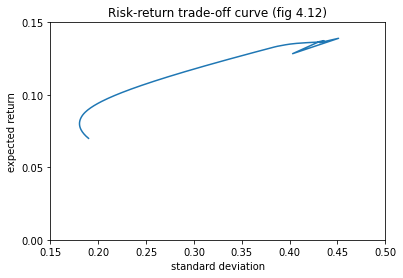

In [ ]:
import pylab
pylab.figure(1, facecolor='w')
pylab.plot(risks, returns)
pylab.xlabel('standard deviation')
pylab.ylabel('expected return')
pylab.axis([0.15, 0.50, 0, 0.15])
pylab.title('Risk-return trade-off curve (fig 4.12)')
pylab.yticks([0.00, 0.05, 0.1, 0.15])

УРА 

Мы построили график границы эффективности!!!

Мы молодцы

Добавим ограничения на веса активов, чтобы они не были меньше 5% и больше 50%

Для этого достаточно исправить матрицу G и вектор h

In [ ]:
G = matrix([[-1.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, -1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, -1.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, -1.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, -1.0],
            [1.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 1.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 1.0]])
G = G.trans()
h = matrix([-0.05,-0.05,-0.05,-0.05,-0.05, 0.5,0.5,0.5,0.5,0.5],(10,1))

In [ ]:
options['show_progress'] = False
r = array([0.09 + i for i in arange(0.0, 0.007, 0.0005)])

portfolios = [qp((P), (q), G, (h), (A), new_return(r[i]))['x'] for i in range(r.size)]
returns = [ dot(cvxopt.matrix(expected_return),x) for x in portfolios]
risks = [ (dot(x, P*x))**0.5 for x in portfolios ]

Положительными оказались веса при 0.09<=r<=0.097

([<matplotlib.axis.YTick at 0x7f66c9efbad0>,
 <a list of 7 Text major ticklabel objects>)

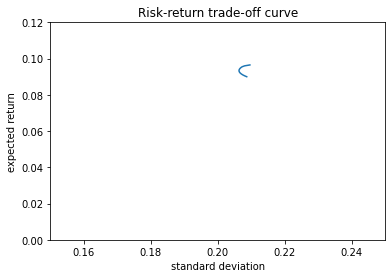

In [ ]:
import pylab
pylab.figure(1, facecolor='w')
pylab.plot(risks, returns)
pylab.xlabel('standard deviation')
pylab.ylabel('expected return')
pylab.axis([0.15, 0.25, 0.0, 0.12])
pylab.title('Risk-return trade-off curve')
pylab.yticks([0.00, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12])

Получилось, что получилось